In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

##### **Dataset**

In [2]:
# Load the data
(X, y), (X_test, y_test) = mnist.load_data()

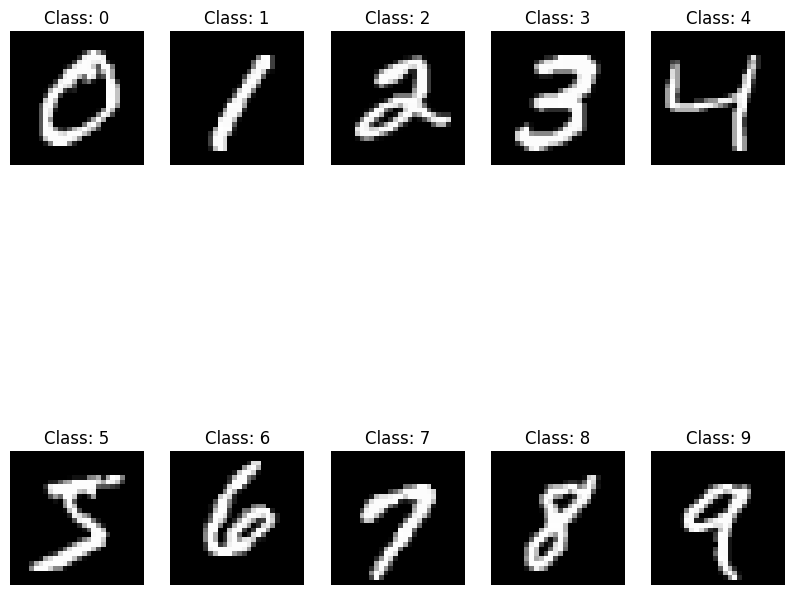

In [3]:
# Create a list to store indices of the first occurrence of each class
indices = []

# Loop over the classes
for i in range(10):
    # Find the index of the first occurrence of this class
    index = np.where(y == i)[0][0]
    indices.append(index)

# Plot one sample for each class
plt.figure(figsize=(10, 10))
for i, index in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[index], cmap='gray')
    plt.title(f"Class: {y[index]}")
    plt.axis('off')
plt.show()

In [4]:
# One-hot encode the target variable
y = to_categorical(y)
y_test = to_categorical(y_test)

In [5]:
# Split the data into training and val sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

##### **Normalization**
The mnist images are 28x28x1 pixels but VGG16 was pretrained by imagenet dataset.Also, we know imagenet pictures are rgb (= 3 channel) and in 32x32 pixels.

So we should repeat data to 3 channel and resize them to input form of network.

In [7]:
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

X_train_rgb = tf.image.resize(X_train_rgb, (32, 32))
X_val_rgb = tf.image.resize(X_val_rgb, (32, 32))
X_test_rgb = tf.image.resize(X_test_rgb, (32, 32))

# Normalize the images to the range used by the pretrained model
X_train = tf.keras.applications.vgg16.preprocess_input(X_train_rgb)
X_val = tf.keras.applications.vgg16.preprocess_input(X_val_rgb)
X_test= tf.keras.applications.vgg16.preprocess_input(X_test_rgb)

In [8]:
print("Training data dimensions:", X_train.shape)
print("Validation data dimensions:",X_val.shape)
print("Testing data dimensions:",X_test.shape)

Training data dimensions: (48000, 32, 32, 3)
Validation data dimensions: (12000, 32, 32, 3)
Testing data dimensions: (10000, 32, 32, 3)


##### **Transfer Learning**

We use Pre-trained Model Approach to load the weights of pre-trained VGG16 on imagenet and add it as a Feature Extraction to my model!

The structure of FC layers is similar to previous CNN model.

In [9]:
# Load the pretrained VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [10]:
# Create the model
model = Sequential()

In [11]:
# Add the VGG base model
model.add(vgg_base)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# freeze VGG16
vgg_base.trainable = False

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model and save the history
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3)

Epoch 1/3
1500/1500 [==============================] - 647s 431ms/step - loss: 0.4566 - accuracy: 0.8726 - val_loss: 0.2607 - val_accuracy: 0.9168
Epoch 2/3
1500/1500 [==============================] - 647s 431ms/step - loss: 0.2241 - accuracy: 0.9275 - val_loss: 0.2202 - val_accuracy: 0.9325
Epoch 3/3
1500/1500 [==============================] - 647s 431ms/step - loss: 0.1893 - accuracy: 0.9384 - val_loss: 0.2092 - val_accuracy: 0.9370


In [14]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

313/313 - 102s - loss: 0.1888 - accuracy: 0.9396 - 102s/epoch - 327ms/step


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 14789258 (56.42 MB)
Trainable params: 74570 (291.29 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


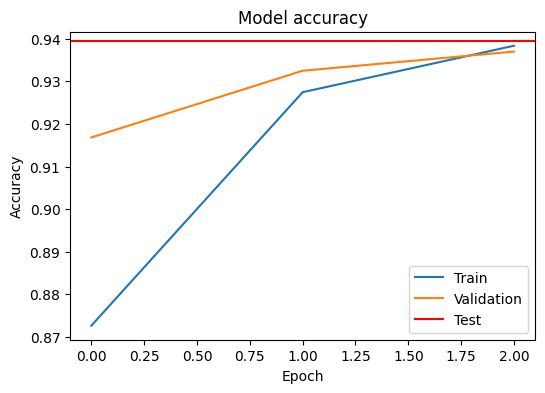

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(y=test_acc, color='r', linestyle='-')  # Add test accuracy to plot
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'])
plt.show()

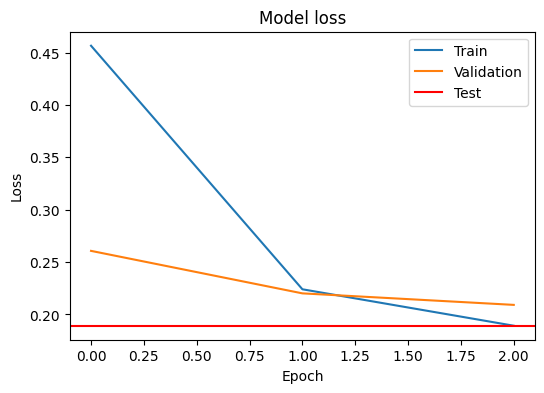

In [17]:
# Plot training & validation loss values
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axhline(y=test_loss, color='r', linestyle='-')  # Add test loss to plot
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'])
plt.show()

In [18]:
# Create a DataFrame for the training, validation, and test loss and accuracy
results = pd.DataFrame({
    'Stage': ['Training', 'Validation', 'Test'],
    'Loss': [history.history['loss'][-1], history.history['val_loss'][-1], test_loss],
    'Accuracy': [history.history['accuracy'][-1], history.history['val_accuracy'][-1], test_acc]
})

results

,Stage,Loss,Accuracy
0,Training,0.189271,0.938375
1,Validation,0.209168,0.937000
2,Test,0.188808,0.939600


313/313 [==============================] - 110s 349ms/step


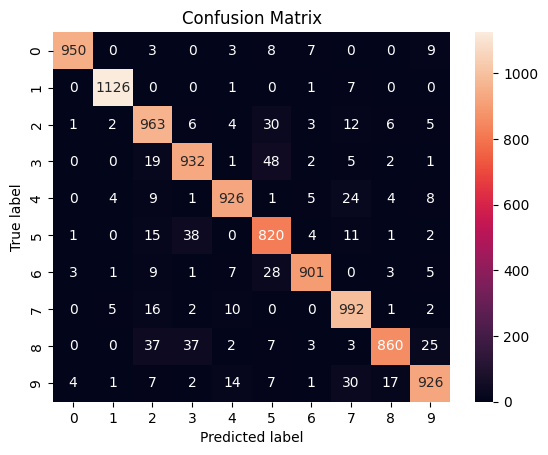

In [19]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()